In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import statsmodels.api as sm
from scipy import stats
from sklearn import datasets, linear_model
from sklearn import datasets, linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

% matplotlib inline
lm = linear_model.LinearRegression()

In [278]:
start_time = time.time()

df=pd.read_csv\
("/Users/thomas/GA-DSI/projects/projects-weekly/project-03/Resources/Iowa_Liquor_sales_sample_10pct_train.csv")
df_test=pd.read_csv\
("/Users/thomas/GA-DSI/projects/projects-weekly/project-03/Resources/Iowa_Liquor_sales_sample_10pct_test.csv")

"""CONVERTING DATA TO BE USABLE; DROPS ~1150 rows out of the 244000; This is acceptable"""

#Date Conversion takes 42 Seconds
#df['Date']=pd.to_datetime(df['Date'])


#---
#Make these float columns; removing the 'dollar' signs
df['Sale (Dollars)']= [np.float(x[1:]) for x in df['Sale (Dollars)']]
df['State Bottle Retail']= [np.float(x[1:]) for x in df['State Bottle Retail']]
df['State Bottle Cost']= [np.float(x[1:]) for x in df['State Bottle Cost']]

#---
#There are Zip Codes with the value 712-2, which is the zip code of IA
df=df.replace("712-2","51529")

#---
#Changed County number from float to int; there were null values before, so we took them out just above this
zips= df[pd.notnull(df["County"])].groupby(['Store Number',"County"])["County"].unique()
store=county=[]

#Splits up the groupyby appropriately
i=0
while i < len(zips):
    store.append(zips.index[i][0])
    county.append(zips.index[i][1])
    i+=1
    
#Puts the store as key and county as value
d={}
for x,y in zip(store,county):
    d[x]=y
d[5230]="Linn";d[5210]="Page";d[5227]="Clinton";d[5247]="Cerro Gordo";d[5236]="Jones";d[5217]="Wayne";
d[5220]="Cerro Gordo";d[5225]="Johnson";d[5226]="Scott";d[5222]="Linn";d[5214]="Linn";d[5240]="Cedar";
d[5233]="Marion";d[5224]="Johnson";d[5237]="Webster";d[5229]="Warren";d[5234]="Dubuque";d[5208]="Cass";
d[5218]="Lucas";d[5216]="Polk";d[5223]="Fremont";d[5232]="Audubon"
    
#Will create a new df for the store number column and overwrite previous values
#Look up every row and see if value is blank. If it is, fill it
for i in range(len(df["City"])):
    if pd.isnull(df.iloc[i,6]):
        df.iloc[i,6]=d[df.iloc[i,2]]
    


#---
#Category Fix
cat = df.set_index('Category')['Category Name'].to_frame()
cat.dropna(inplace=True)
undefined_cats = pd.DataFrame([["Moonshine"],["Reposado"],["Vodka"],["Hennessy"],["Spiced Rum"],["Rum"],\
                               ["Amaretto"],["Spirit"],["Moonshine"],["Moonshine"],["Rum"]], \
                              columns=['Category Name'], index=['1011700.0', '1022200.0', '1032100.0', '1052100.0',\
                        '1062400.0', '1062500.0', '1082100.0', '1082200.0', '1091100.0', '1091300.0', '1092100.0'])
all_cats = pd.concat([cat, undefined_cats])

def get_category_name(category):
    return all_cats.T[str(float(category))].values[0]

category_wo_name = df[pd.isnull(df["Category Name"])]["Category"].to_frame()

for row in category_wo_name.index:
    if not np.isnan(category_wo_name.ix[row]['Category']):
        df.set_value(row, 'Category Name', get_category_name(category_wo_name.ix[row]['Category']))

#---
#Delete Useless Columns
del df["County Number"]
del df["Category"]
#---
#Change city column to all uppercase
df["City"]=df["City"].apply(lambda X: X.upper())

#---
#Create dictionary to fill in the null County values for each city
print("--- %s seconds ---" % (time.time() - start_time))

--- 55.3738660812 seconds ---


In [407]:
dfd=pd.read_csv("Resources/IA_Data_Master.csv")
copy=df.copy()
copy=pd.merge(df,dfd,how='inner',on='County')
copy=copy[pd.notnull(copy["Sale (Dollars)"])]
copy['Store Number']=1
copy['Category Name']=1
copy=copy.groupby('County')['Bottles Sold','Sale (Dollars)','Housing Estimate','Population Estimate',\
        'Per Capita Yearly Income','Store Number','Volume Sold (Liters)','Category Name'].sum()
copy["Sale/Person"]=copy["Sale (Dollars)"]/copy["Population Estimate"]
copy["Store/Person"]=copy["Store Number"]/copy["Population Estimate"]
copy["Sale/Store"]=copy["Sale (Dollars)"]/copy["Store Number"]
copy["Avg Store Size"]=copy["Category Name"]/copy["Store Number"]

In [415]:
max(dfd["Population Estimate"])

467711

In [412]:
copy2=copy[['Per Capita Yearly Income','Housing Estimate','Population Estimate']].copy()
cols=[x for x in copy2]
for x in cols:
    for y in cols:
        if x.index<=y.index:
            copy2[x+"*"+y]=copy2[x]*copy2[y]
        if x.index<y.index:
            copy2[x+"/"+y]=copy2[x]/copy2[y]
        if x.index>y.index:
            copy2[x+"/"+y]=copy2[y]/copy2[x]
    copy2["LOG of "+x]=np.log(copy2[x])
cols=[x for x in copy2]

In [316]:
#plt.hist(copy['Volume Sold (Liters)']/copy['Bottles Sold'],bins=30)
#plt.show()
#plt.hist(copy['Store Number'],bins=30)
#plt.show()

In [416]:
print "Sale/Person"
print copy['Sale/Person'].sort_values(ascending=False)[0:20]
top20=copy['Sale/Person'].sort_values(ascending=False).index[0:20]
print 
print "Population"
print copy['Population Estimate'][top20]
top20=copy['Population Estimate'][top20].index
print 
print "Store/Person"
print copy['Store/Person'][top20]
#Howard and Shelby Looks 

Sale/Person
County
Ringgold      0.018046
Ida           0.017656
Fremont       0.017328
Howard        0.016639
Audubon       0.014318
Osceola       0.014204
Adams         0.014070
Shelby        0.013168
Worth         0.013078
Adair         0.012953
Wayne         0.012800
Pocahontas    0.012305
Monroe        0.012207
Van Buren     0.012092
Lucas         0.011765
Clarke        0.011449
Humboldt      0.011258
Greene        0.010898
Decatur       0.010218
Winnebago     0.009560
Name: Sale/Person, dtype: float64

Population
County
Ringgold       932512
Ida           4005960
Fremont        186462
Howard        5166090
Audubon       1160373
Osceola       1956972
Adams          816140
Shelby        7132346
Worth         2634012
Adair         3852524
Wayne         1015215
Pocahontas    3356832
Monroe        2607171
Van Buren     1578960
Lucas         3811398
Clarke        5888724
Humboldt      5064150
Greene        5533551
Decatur       1644000
Winnebago     9049477
Name: Population Estimate, d

Score: 0.77874879741
Alpha: 0.0001



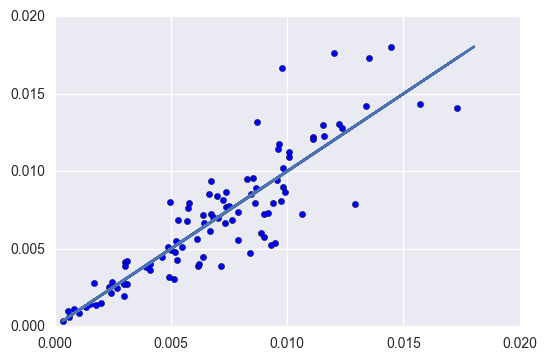

<function matplotlib.pyplot.plot>

In [413]:
copy2=copy[['Per Capita Yearly Income','Housing Estimate','Population Estimate']].copy()
cols=[x for x in copy2]
for x in cols:
    for y in cols:
        if x.index<=y.index:
            copy2[x+"*"+y]=copy2[x]*copy2[y]
        if x.index<y.index:
            copy2[x+"/"+y]=copy2[x]/copy2[y]
        if x.index>y.index:
            copy2[x+"/"+y]=copy2[y]/copy2[x]
    #copy2["LOG of "+x]=np.log10(x)
cols=[x for x in copy2]
y=copy['Sale/Person']
x=copy2[cols]
nums=np.linspace(0.0001,10,500)
alpha=nums
bestscore=0
bestalpha=0

for a in alpha:

    #model=lm.fit(x,y)
    model = Ridge(alpha=a)
    model.fit(x,y)
    predictions=model.predict(x)

    if (model.score(x,y),a)>bestscore:
        bestscore= model.score(x,y),a
        bestalpha=a


a=bestalpha
model = Ridge(alpha=a)
model.fit(x,y)
#model=lm.fit(x,y)
predictions=model.predict(x)

print "Score:",model.score(x,y)
print "Alpha:",a
print 
coef= [[i,j] for i,j in zip(cols,model.coef_)]
for x in coef:
    if np.abs(x[1])>1:
        print x
plt.scatter(predictions,y)
plt.plot(y,y)
plt.xlim(0,.02)
plt.ylim(0,.02)
plt.show()
plt.plot

In [389]:
np.std((predictions-y)/copy['Sale/Person'])

0.29184569077037986

We really need to try to predict sales per store with the regression. We can obviously make a few regressions to test, and we have, but what needs to be answered now is how we are going to test and with what.

In [276]:
y=copy['Sale (Dollars)']
cols=['Housing Estimate/Population Estimate','Per Capita Yearly Income/Housing Estimate',\
        'Per Capita Yearly Income/Population Estimate','Store Number','Housing Estimate/Store Number']
x=copy2[cols]
nums=np.linspace(0,50,500)
alpha=nums
bestscore=0
bestalpha=0

for a in alpha:
    #model=lm.fit(x,y)

    model = Ridge(alpha=a)
    model.fit(x,y)
    predictions=model.predict(x)

    if (model.score(x,y),a)>bestscore:
        bestscore= model.score(x,y),a
        bestalpha=a


a=bestalpha
model = Ridge(alpha=a)
model.fit(x,y)
predictions=model.predict(x)

print "Score:",model.score(x,y)
print "Alpha:",a
print 
coef= [[i,j] for i,j in zip(cols,model.coef_)]
for x in coef:
    if np.abs(x[1])>1:
        print x

#Values indicate the lonelier the population, i.e. more houses and less people, the more likely people are to buy
#alcohol. Additionally, the more wealthty per house, the likely for people to buy alcohol.

Score: 0.991994600838
Alpha: 0.0

['Housing Estimate/Population Estimate', -32874.502950076756]
['Per Capita Yearly Income/Housing Estimate', 53183.518865566017]
['Per Capita Yearly Income/Population Estimate', -80913.422719241746]
['Store Number', 156.84339300521003]
['Housing Estimate/Store Number', 34726366.680066936]


In [279]:
df.columns

Index([u'Unnamed: 0', u'Date', u'Store Number', u'City', u'Zip Code',
       u'County', u'Category Name', u'Vendor Number', u'Item Number',
       u'Item Description', u'Bottle Volume (ml)', u'State Bottle Cost',
       u'State Bottle Retail', u'Bottles Sold', u'Sale (Dollars)',
       u'Volume Sold (Liters)', u'Volume Sold (Gallons)'],
      dtype='object')

Will use Amish's model to find the highest positive delta counties for predicting total sales per store using median income, population, average of unique items sold in store (size), number of houses, houses/person. The delta indicates an unknown variable, which indicates that, if positive, the population is drinking more than predicted, and, if negative, the population is drinking less than predicted.

The model takes the natural log of both sides. We do this because the data is skewed, and needs to be normalized.

With those highest positive delta counties, we found the largest population centers (towns/cities) within them, and analyzed their suitability. We only selected the counties with a delta of 0.2 or above, which was 12 counties. We pulled the same metrics that we had for counties, which were median income, population, number of houses.

In [417]:
l=['ACKLEY', 'ALDEN', 'ELDORA', 'FORT DODGE', 'HUBBARD', 'IOWA FALLS',\
      'AFTON', 'CRESTON', 'BELMOND', 'CLARION', 'DOWS', 'EAGLE GROVE',\
      'GOLDFIELD', 'BRITT', 'CORWITH', 'GARNER', 'BURLINGTON', 'DANVILLE',\
      'MEDIAPOLIS', 'WEST BURLINGTON', 'CARROLL', 'COON RAPIDS',\
      'GLIDDEN', 'MANNING', 'DECORAH', 'FORT ATKINSON', 'DELAWARE',\
      'DELHI', 'MANCHESTER', 'FAIRFIELD', 'GLENWOOD', 'MALVERN',\
      'PACIFIC JUNCTION', 'HOLSTEIN', 'IDA GROVE', 'OSCEOLA']

In [418]:
for x in l:
    print x

ACKLEY
ALDEN
ELDORA
FORT DODGE
HUBBARD
IOWA FALLS
AFTON
CRESTON
BELMOND
CLARION
DOWS
EAGLE GROVE
GOLDFIELD
BRITT
CORWITH
GARNER
BURLINGTON
DANVILLE
MEDIAPOLIS
WEST BURLINGTON
CARROLL
COON RAPIDS
GLIDDEN
MANNING
DECORAH
FORT ATKINSON
DELAWARE
DELHI
MANCHESTER
FAIRFIELD
GLENWOOD
MALVERN
PACIFIC JUNCTION
HOLSTEIN
IDA GROVE
OSCEOLA
